In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import statistics
from gym import spaces
from gym.utils import seeding
import math

In [171]:
class RouletteEnv(gym.Env):
    """Simple roulette environment
    The roulette wheel has 37 spots. If the bet is 0 and a 0 comes up,
    you win a reward of 35. If the parity of your bet matches the parity
    of the spin, you win 1. Otherwise you receive a reward of -1.
    The long run reward for playing 0 should be -1/37 for any state
    The last action (38) stops the rollout for a return of 0 (walking away)
    """
    def __init__(self, spots=38):
        self.n = spots + 1
        self.action_space = spaces.Discrete(self.n)
        self.observation_space = spaces.Discrete(1)
        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == self.n - 1:
            # observation, reward, done, info
            return 0, 0, True, {}

        # N.B. np.random.randint draws from [A, B) while random.randint draws from [A,B]
        val = self.np_random.randint(0, self.n - 1)
        if val == action :
            reward = -0.0526*self.n+self.n-1
        else:
            reward = -1.0
            
        return 0, reward, False, {}

    def reset(self):
        return 0

In [172]:
def Bias_cor(bM,Var):
    
    return (0.5774/bM+bM)*Var**0.5

def bM(M,constant=7):
    # bM := (2log(M+7)-log(log(M+7))-log4pi)**0.5
    return (2*math.log(M+constant) - math.log(math.log(M+constant))-math.log(4*math.pi))**0.5

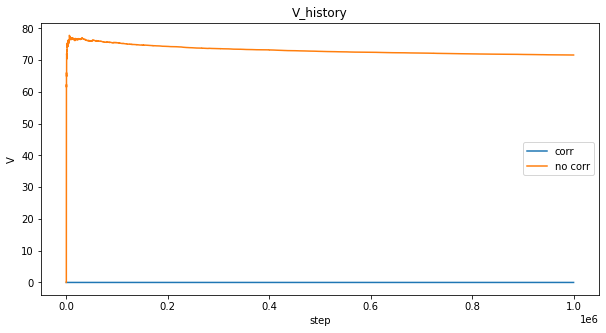

In [179]:
# action = 0~37 bet spot
# action = 38  no bet
#Total number of action = 39
# Q - Learning

spot_num = 38
warmup = 1000
env = RouletteEnv(spots=spot_num)
gamma = 0.99
plt.figure(figsize=(10,5))
state = env.reset()

#line_number
for line in range(1):

    V_history      = []
    V_history_corr = []
    Q      = np.zeros(spot_num+1)
    Q_corr = np.zeros(spot_num+1)
    R_dict = np.zeros((spot_num+1,5))
    # R_dict 
    # ( 0  ,  1  ,  2   ,     3     ,     4   )
    # (num , sum , mean ,square_sum , variance)
    epoch = []
    
    for i in range(1000000):
        
        alpha = 100/(i+100)
        #alpha = 400/(i+400)
        policy = random.randint(0,spot_num)  #random explore
        #policy = np.argmax(Q_corr)     #greedy
        s,r,done,_ = env.step(policy)
        
        
        R_dict[policy,0] += 1
        R_dict[policy,1] += r
        R_dict[policy,2]  = R_dict[policy,1]/R_dict[policy,0]
        R_dict[policy,3] += r**2
        R_dict[policy,4]  = R_dict[policy,3]/R_dict[policy,0] - R_dict[policy,2]**2
        
        
        if R_dict[policy,0]>warmup:
            B = Bias_cor(bM(spot_num+1), R_dict[policy,4])
            Q_corr[policy] = (1-alpha) * Q_corr[policy] + alpha * (R_dict[policy,2] + gamma * Q_corr.max() - B)          
        
        V_history_corr.append( Q_corr.max() )
        epoch.append(i)
        
        Q[policy] = (1-alpha) * Q[policy] + alpha * (r + gamma * Q.max())
        V_history.append( Q.max() )
        
        
    plt.plot(epoch,V_history_corr,label="corr")
    plt.plot(epoch,V_history,label="no corr")


#plt.xlim(0,1000000)
#plt.ylim(-10,350)
plt.title("V_history") 
plt.ylabel("V")
plt.xlabel("step")
plt.legend()
plt.show()

In [176]:
#final Q
Q_corr[:]

array([-91.23137064, -91.07199698, -91.17437013, -91.3370591 ,
       -91.28599699, -91.15648612, -91.00098238, -91.25446139,
       -91.07157679, -91.30902776, -91.30099061, -91.06369328,
       -91.22574475, -91.35399168, -91.2530251 , -91.35982851,
       -91.09437265, -91.1300721 , -91.23456838, -91.20764251,
       -90.99827207, -91.15265258, -91.0687254 , -91.0137518 ,
       -91.23119264, -91.18067016, -91.28324804, -91.18723752,
       -91.31061442, -91.14829752, -91.08675832, -91.20666615,
       -91.0712829 , -91.20546036, -91.03351794, -91.26743016,
       -91.17378167, -91.16234079, -91.19843215])

In [177]:
# exceptation of C(s,a)
R_dict[:,2]

array([-0.06548278, -0.02142202, -0.02630183, -0.08707156, -0.08471338,
       -0.03886741,  0.03045637, -0.05425591, -0.04152388, -0.04277495,
       -0.05792309, -0.04709597, -0.02593695, -0.04823292,  0.04478218,
       -0.05490271, -0.01814506, -0.07516508, -0.06196997, -0.05894411,
       -0.03651404,  0.03622452,  0.05172261, -0.02595194, -0.02396127,
       -0.02576651, -0.05274833, -0.01493442, -0.0442237 , -0.02664384,
       -0.05252605, -0.05297186, -0.03084685, -0.01796299, -0.02862367,
       -0.10018193,  0.00289669, -0.07784613,  0.        ])

<AxesSubplot:>

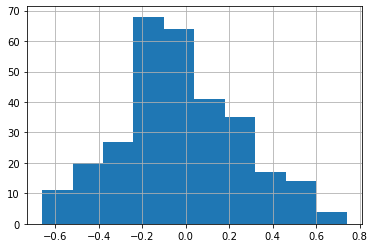

In [126]:
from pandas import Series,DataFrame
values = Series(R_dict[:,2])
values.hist(bins=10)

In [134]:
sum = 0
for i in range(100000):
    sum += -0.0526*0.99**i
print(sum)

-5.25999999999997
